In [1]:
import numpy as np
import torch

from bikebench.design_evaluation.design_evaluation import *
from bikebench.data_loading import data_loading
from bikebench.conditioning import conditioning
from bikebench.benchmarking.scoring import *
from bikebench.benchmarking.score_report import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/mileva/mambaforge/envs/bike-bench-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup
We first load up the main Bike-Bench predictive modeling dataset.

In [2]:
data = data_loading.load_bike_bench_train()
data_tens = torch.tensor(data.values, dtype=torch.float32, device=device)

 We will use Bike-Bench's standard set of evaluations, provided by ```get_standard_evaluations()```, however for specific purposes you may handpick evaluation functions. 

In [3]:
evaluations_list = get_standard_evaluations(device, aesthetics_mode="Embedding")
print(evaluations_list)

# The evaluation function list can alternatively be customized
# evauations_list = [UsabilityEvaluator(device=device), AeroEvaluator(device=device)]

[<bikebench.design_evaluation.design_evaluation.UsabilityEvaluator object at 0x731d107219f0>, <bikebench.design_evaluation.design_evaluation.AeroEvaluator object at 0x731d10722230>, <bikebench.design_evaluation.design_evaluation.ErgonomicsEvaluator object at 0x731d10723970>, <bikebench.design_evaluation.design_evaluation.AestheticsEvaluator object at 0x731d10723940>, <bikebench.design_evaluation.design_evaluation.StructuralEvaluator object at 0x731d10722380>, <bikebench.design_evaluation.design_evaluation.FrameValidityEvaluator object at 0x731d107223e0>, <bikebench.design_evaluation.design_evaluation.ValidationEvaluator object at 0x731d0ed158a0>]


We initialize the evaluator. We use the ```construct_tensor_evaluator()``` which is gradient-enabled. We also have to pass in the column names so that the evaluator knows which column is which (evaluation functions look for specific columns from the bike-bench data). A dataframe version exists called ```construct_dataframe_evaluator()```, but does not preserve gradients. In either case, we pass in the list of evaluation functions and the function builds a evaluator callable, as well as a set of requirement names (list of strings) and types (list - 1 = objective; 0=constraint). 

In [4]:
evaluator, requirement_names, is_objective, is_conditional = construct_tensor_evaluator(evaluations_list, data.columns)
print(evaluator)
print(requirement_names)
print(is_objective)
print(is_conditional)

<function construct_tensor_evaluator.<locals>.evaluate_tensor at 0x731d1072b760>
['Usability Score', 'Drag Force (N)', 'Knee Angle Error (deg.)', 'Hip Angle Error (deg.)', 'Arm Angle Error (deg.)', 'Arm Too Long for Bike', 'Saddle Too Far From Handle', 'Torso Too Long for Bike', 'Saddle Too Far From Crank', 'Upper Leg Too Long for Bike', 'Lower Leg Too Long for Bike', 'Cosine Distance to Embedding', 'Mass (kg)', 'Planar Compliance Score', 'Transverse Compliance Score', 'Eccentric Compliance Score', 'Planar Safety Factor', 'Eccentric Safety Factor', 'Predicted Frame Validity', 'Saddle height too small', 'Saddle collides with seat tube', 'Saddle too short', 'Head angle over limit', 'Seat angle over limit', 'Seat post too short', 'Seat post too long', 'Rear Wheel inner diameter too small', 'Front Wheel inner diameter too small', 'Seat tube extension longer than seat tube', 'Head tube upper extension and lower extension overlap', 'Seat stay junction longer than seat tube', 'Non-negative pa

Bike-Bench's evaluation functions are designed to be used with a set of conditions. We have provided simple interfaces to sample randomized conditions. Different evaluation functions require different conditioning. Thus you may be able to leave some conditioning information blank. However, for the full set of evaluations, rider geometry, use case and one of three aesthetics conditions (embedding, text, image) are required. Conditional information's outer dimension (batch size) must match the data to evaluate's batch size. As an exception, a condition batch size of 1 is permissable, in which case it is applied to the entire batch of data evaluated, as shown below.  

In [5]:
num_condition = 1
rider_condition = conditioning.sample_riders(num_condition, split="test")
use_case_condition = conditioning.sample_use_case(num_condition, split="test")

image_embeddings = conditioning.sample_embedding(num_condition, split="test")
condition = {"Rider": rider_condition, "Use Case": use_case_condition, "Embedding": image_embeddings}

# Example Alternative: sample or create a text condition
# text_condition = conditioning.sample_text(num_condition, split="test")
# evaluations_list = get_standard_evaluations(device, aesthetics_mode="Text")
# evaluator, requirement_names, requirement_types = construct_tensor_evaluator(evaluations_list, data.columns)
# text_condition = ["Futuristic black racing bike"]
# condition = {"Rider": rider_condition, "Use Case": use_case_condition, "Text": text_condition}

### Calling Evaluators
Lets try calling the evaluator on the data. We receive an 3600 x 25 (batch size x n_obj+n_const) tensor as a result. 

In [6]:
eval_scores = evaluator(data_tens, condition)
print(eval_scores.shape)

torch.Size([3045, 50])


All objective scores are ideally minimized at 0. Maximum values for objective scores very. Some are theoretically unbounded. 

In [7]:
objective_scores = eval_scores[:, np.array(is_objective, dtype=bool)]
mean_scores = torch.mean(objective_scores, dim=0).detach().cpu().numpy()
min_scores = torch.min(objective_scores, dim=0).values.detach().cpu().numpy()
print(f"Mean Objective Scores: {mean_scores.round(3)}")
print(f"Min Objective Scores: {min_scores.round(3)}")

Mean Objective Scores: [ 0.511 22.309 32.108  8.177 11.907  0.364  2.76   2.388  2.22   2.066]
Min Objective Scores: [0.    5.605 0.    0.    0.    0.352 0.015 0.    0.268 0.103]


Constraints are considered satsfied if the score value is less or equal to 0. Positive constraint values indicate a constraint violation with the magnitude of the score indicating the degree of constraint violation. 

In [8]:
constraint_scores = eval_scores[:, ~np.array(is_objective, dtype=bool)]
constraint_satisfied = constraint_scores <= 0
mean_csr = torch.mean(constraint_satisfied.to(float), dim=0)
print(f"Constraint satisfaction rates: {mean_csr.detach().cpu().numpy().round(3)}")

Constraint satisfaction rates: [1.    0.999 1.    0.909 1.    1.    0.049 0.216 0.99  0.998 0.987 0.943
 1.    1.    0.983 0.99  0.999 0.999 1.    0.98  1.    1.    1.    1.
 0.996 0.958 1.    0.999 0.801 0.995 1.    0.992 0.995 0.89  0.912 0.973
 0.837 0.994 0.967 1.   ]


We can verify that gradient calculations are working as expected:

In [9]:
#calcualte gradient of scores wrt data_tens

data_tens.requires_grad = True
eval_scores = evaluator(data_tens, condition)
score_sum = eval_scores.sum()
score_sum.backward()

#check for infs and nans in gradients
if torch.isinf(data_tens.grad).any() or torch.isnan(data_tens.grad).any():
    print("Gradient contains infs or nans!")
else:
    print("Gradient is valid.")

Gradient is valid.


### Scoring

Next, we construct the scoring functions. Whereas the evaluators evaluate individual design performance, the scoring functions evaluate the aggregrate quality of a set of design solutions. There are two preset scoring configurations. ```MainScores``` returns the standard maximum mean discrepancy (MMD), hypervolume, and constraint satisfaction rate metrics. ```DetailedScores``` gives a detailed scoring breakdown including min and mean objective scores, constraint violation rate, and mean constraint violation magnitude. 

In [10]:
main_scorer = construct_scorer(MainScores, evaluations_list, data.columns, device)
detailed_scorer = construct_scorer(DetailedScores, evaluations_list, data.columns, device)

In [11]:
main_scores = main_scorer(data_tens.detach(), condition)
main_scores

Design Quality ↑ (HV)      0.008910
Constraint Violation ↓     2.648276
Sim. to Data ↓ (MMD)       0.000809
Novelty ↑                  5.835689
Binary Validity ↑          0.018062
Diversity ↓ (DPP)         15.799931
dtype: float64

In [12]:
detailed_scores = detailed_scorer(data_tens.detach(), condition)
detailed_scores

Individual Min Objective Score ↓: Usability Score                                         0.194034
Individual Min Objective Score ↓: Drag Force (N)                                         12.864904
Individual Min Objective Score ↓: Knee Angle Error (deg.)                                 0.000000
Individual Min Objective Score ↓: Hip Angle Error (deg.)                                  0.000000
Individual Min Objective Score ↓: Arm Angle Error (deg.)                                  0.000000
                                                                                           ...    
Individual Mean Constraint Violation Magnitude ↓: Top tube improperly joins head tube     0.271558
Individual Mean Constraint Violation Magnitude ↓: Top tube improperly joins seat tube     1.221872
Individual Mean Constraint Violation Magnitude ↓: Down tube intersects front wheel        0.050551
Individual Mean Constraint Violation Magnitude ↓: Saddle hits top tube                    0.007914
Individual

### Model Scorecards
Bike-Bench provides some visualization dashboards for model performance. Lets try them out. Each model scorecard shows the model's performance relative to other models. We first split up portions of the dataset to simulate sample sets taken from different generative models. The scorecard shows ranks and scores in the principal metrics (MMD, hypervolume, CSR) with competing models indicated with gray ticks. It also shows distributions of objective scores with other models' distributions in gray. Objective plots also show mean objective scores for the model in question and other models benchmarked, as well as the rank of the mean objective score for each objective. Finally, the scorecard shows constraint satisfaction rates and ranks. Lets try it on our dataset (in this case there will be no comparison, but ordinarily we may compare generated designs to the dataset, for example).

/home/mileva/Documents/Lyle/Bike-Bench-Internal/src/bikebench/benchmarking/score_report.py:147: UserWarning: No model_colors provided; using Matplotlib cycle.
  warnings.warn("No model_colors provided; using Matplotlib cycle.")


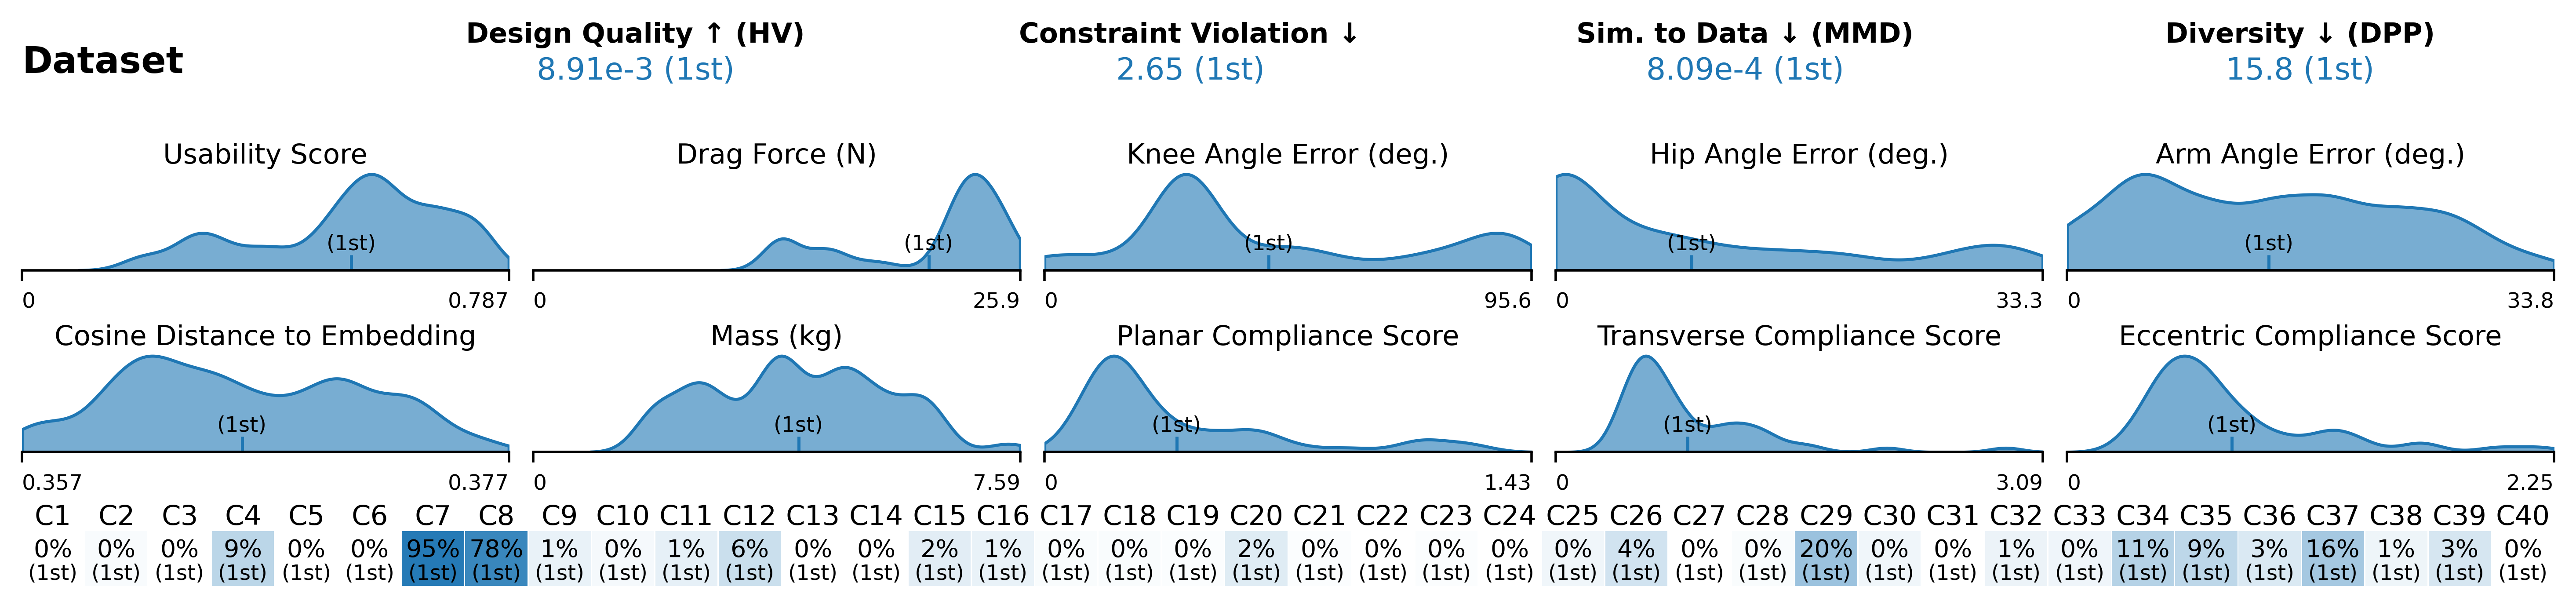

In [13]:
from bikebench.benchmarking import score_report
all_evaluation_scores_dict = {f"Dataset": eval_scores}
main_scores_dict = {f"Dataset": main_scores}

dashboard = score_report.ScoreReportDashboard(
    requirement_scores=all_evaluation_scores_dict,
    overall_scores=main_scores_dict,
)

for m in all_evaluation_scores_dict.keys():
    dashboard.show_model(m)
